In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import functools
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/drug-classification/drug200.csv


Original paper of how to deal with structured data and csv data with tensorflow:
https://www.tensorflow.org/tutorials/load_data/csv  
This is just my experiment with drug200 dataset.

In [2]:
plt.style.use('ggplot')
tf.get_logger().setLevel('ERROR')

### Data overview 

In [3]:
data = pd.read_csv("../input/drug-classification/drug200.csv")

In [4]:
data.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [5]:
data.shape[0]

200

In [6]:
data.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

So, we have:
* Few observations (200)
* No missing values
* Two numerical features
* Three categorical features
* Categorical target column

### Creating tf dataset

In [7]:
TARGET_COLUMN = "Drug"
BATCH_SIZE = 4

In [8]:
target_labels = data.Drug.unique()

On the one hand, we can't just pass strings as features to the model. On the other hand, we don't want to make another csv dataset with encoded target column. So we create mapping function. In tensorflow we use StringLookup for this purposes.

In [9]:
drugs_ind = tf.keras.layers.experimental.preprocessing.StringLookup(
                        vocabulary=list(target_labels), num_oov_indices=0, mask_token=None)

In [10]:
ds = tf.data.experimental.make_csv_dataset(
      "../input/drug-classification/drug200.csv",
      batch_size=BATCH_SIZE,
      label_name=TARGET_COLUMN,
      na_value="?",
      num_epochs=1,
      ignore_errors=True)

In [11]:
def show_batch(dataset):
    for batch, label in dataset.take(1):
        for key, value in batch.items():
            print("{:20s}: {}".format(key,value.numpy()))

In [12]:
show_batch(ds)

Age                 : [20 60 31 57]
Sex                 : [b'F' b'F' b'M' b'F']
BP                  : [b'LOW' b'HIGH' b'HIGH' b'NORMAL']
Cholesterol         : [b'NORMAL' b'HIGH' b'NORMAL' b'HIGH']
Na_to_K             : [11.686 13.303 11.871 14.216]


Ok, let's define numerical and categorical features

In [13]:
NUMERIC_FEATURES = ['Age','Na_to_K']

In [14]:
CATEGORIES = {k: data[k].unique().tolist() for k in data if k not in NUMERIC_FEATURES}
CATEGORIES

{'Sex': ['F', 'M'],
 'BP': ['HIGH', 'LOW', 'NORMAL'],
 'Cholesterol': ['HIGH', 'NORMAL'],
 'Drug': ['DrugY', 'drugC', 'drugX', 'drugA', 'drugB']}

In [15]:
target_labels = CATEGORIES.pop("Drug")
target_labels

['DrugY', 'drugC', 'drugX', 'drugA', 'drugB']

Now, we have to preprocess features

In [16]:
class PreprocessFeatures(object):
    def __init__(self, names, labels_map):
        self.names = names
        self.labels_map = labels_map

    def __call__(self, features, labels):
        numeric_freatures = [features.pop(name) for name in self.names]
        numeric_features = [tf.cast(feat, tf.float32) for feat in numeric_freatures]
        numeric_features = tf.stack(numeric_features, axis=-1)
        features['numeric'] = numeric_features
        labels = self.labels_map(labels)
        return features, labels

In [17]:
ds = ds.map(PreprocessFeatures(NUMERIC_FEATURES,drugs_ind))

### Handle numerical features

In [18]:
desc = data[NUMERIC_FEATURES].describe()
desc

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [19]:
MEAN = np.array(desc.T['mean'])
STD = np.array(desc.T['std'])

In [20]:
def normalize_numeric_data(data, mean, std):
    return (data-mean)/std

In [21]:
normalizer = functools.partial(normalize_numeric_data, mean=MEAN, std=STD)

In [22]:
numeric_column = tf.feature_column.numeric_column('numeric', normalizer_fn=normalizer, shape=[len(NUMERIC_FEATURES)])
numeric_columns = [numeric_column]

### Handle categorical features

In [23]:
categorical_columns = []
for feature, vocab in CATEGORIES.items():
    cat_col = tf.feature_column.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab)
    categorical_columns.append(tf.feature_column.indicator_column(cat_col))

### Creating preprocessing layers

In [24]:
preprocessing_layer = tf.keras.layers.DenseFeatures(categorical_columns + numeric_columns)

### Define model

In [25]:
model = tf.keras.Sequential([
  preprocessing_layer,
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(target_labels), activation='sigmoid'),
])

In [26]:
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy())

### Train test split

In [27]:
N = data.shape[0]
train_size = 0.8
n_train = int(N*train_size)
take_train = n_train // BATCH_SIZE

In [28]:
train_ds = ds.take(take_train)
test_ds = ds.skip(take_train) 

### Fit the model

In [29]:
history = model.fit(train_ds, 
                    validation_data=test_ds,
                    epochs=20)

Epoch 1/20
40/40 [==============================] - 0s 9ms/step - loss: 1.4486 - sparse_categorical_accuracy: 0.4812 - val_loss: 1.2247 - val_sparse_categorical_accuracy: 0.6000
Epoch 2/20
40/40 [==============================] - 0s 3ms/step - loss: 1.0070 - sparse_categorical_accuracy: 0.6500 - val_loss: 0.7248 - val_sparse_categorical_accuracy: 0.8000
Epoch 3/20
40/40 [==============================] - 0s 3ms/step - loss: 0.5556 - sparse_categorical_accuracy: 0.7937 - val_loss: 0.3734 - val_sparse_categorical_accuracy: 0.9500
Epoch 4/20
40/40 [==============================] - 0s 3ms/step - loss: 0.3079 - sparse_categorical_accuracy: 0.9375 - val_loss: 0.2609 - val_sparse_categorical_accuracy: 0.9500
Epoch 5/20
40/40 [==============================] - 0s 3ms/step - loss: 0.2138 - sparse_categorical_accuracy: 0.9375 - val_loss: 0.1663 - val_sparse_categorical_accuracy: 0.9750
Epoch 6/20
40/40 [==============================] - 0s 3ms/step - loss: 0.1217 - sparse_categorical_accuracy: 

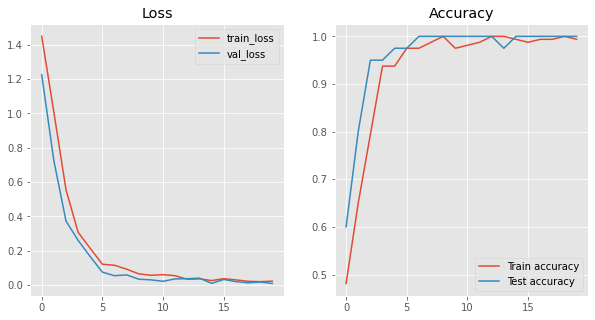

In [30]:
rows, cols = 1, 2
fig, axs = plt.subplots(rows, cols, figsize=(10,5))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Loss')
axs[0].legend(['train_loss','val_loss'])

axs[1].plot(history.history['sparse_categorical_accuracy'])
axs[1].plot(history.history['val_sparse_categorical_accuracy'])
axs[1].set_title('Accuracy')
axs[1].legend(['Train accuracy','Test accuracy'])

In [31]:
print("Pred: \t   True:")
for X, y in test_ds:
    pred = model(X)
    print(f"{tf.argmax(pred,axis=1)}  {y}")

Pred: 	   True:
[2 0 0 0]  [2 0 0 0]
[0 0 0 2]  [0 0 0 2]
[1 0 2 2]  [1 0 2 2]
[0 2 0 1]  [0 2 0 1]
[0 2 2 2]  [0 2 2 2]
[4 2 2 0]  [4 2 2 0]
[0 0 1 4]  [0 0 1 4]
[1 2 3 0]  [1 2 3 0]
[0 0 2 0]  [0 0 2 0]
[0 3 2 0]  [0 3 2 0]
